# Data Exploration


## Import Libraries

In [209]:
import sys
import os
import importlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
	sys.path.append(module_path)

import src.utils
importlib.reload(src.utils)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.utils import create_id_champ_map, get_unique_champs_from_df, get_win_counts, RANK_COLORS, RANK_ORDER
from numpy.typing import ArrayLike
from pandas import DataFrame


## Utils

In [210]:
champ_id_map = create_id_champ_map(reverse_map=True)
id_champ_map = create_id_champ_map()

champ_id_map.pop("No Champion")
id_champ_map.pop(0)

print("Printing the first 5 keys in each map.")
print({ id: id_champ_map[id] for id in range(1, 6) })

Printing the first 5 keys in each map.
{1: 'Annie', 2: 'Olaf', 3: 'Galio', 4: 'TwistedFate', 5: 'XinZhao'}


## Dataset Overview

In [211]:
matches = pd.read_csv("../data/TeamMatchTbl.csv")
matches.head()

,TeamID,MatchFk,B1Champ,B2Champ,B3Champ,B4Champ,B5Champ,R1Champ,R2Champ,R3Champ,...,BlueDragonKills,BlueTowerKills,BlueKills,RedBaronKills,RedRiftHeraldKills,RedDragonKills,RedTowerKills,RedKills,RedWin,BlueWin
0,1,EUW1_7565751492,897,154,157,51,902,164,5,25,...,1,3,13,1,0,3,8,26,1,0
1,2,EUW1_7565549583,82,238,157,236,89,6,254,127,...,3,10,39,0,1,1,3,33,0,1
2,3,EUW1_7564803077,516,28,4,498,235,23,64,38,...,2,7,27,2,0,3,8,37,1,0
3,4,EUW1_7564368646,54,34,59,498,103,61,25,55,...,0,4,55,0,0,0,0,39,0,1
4,5,EUW1_7564332041,12,800,111,150,142,141,101,55,...,0,0,42,0,0,0,0,0,0,1


In [212]:
blue_champ_cols = ["B1Champ", "B2Champ", "B3Champ", "B4Champ", "B5Champ"]
red_champ_cols = ["R1Champ", "R2Champ", "R3Champ", "R4Champ", "R5Champ"]
targets = ["RedWin", "BlueWin"]
relevant_features = blue_champ_cols + red_champ_cols

print("=" * 50)
print("Preliminary Dataset Info")
print("=" * 50)

print("Shape: " + str(matches.shape))
print()

print("Pre-match features: " + str(len(relevant_features)))
print(relevant_features)
print()

# We drop these because we're trying to predict the outcome using only pre-match information (champ picks).
print("Post-match features: " + str(matches.drop(columns=relevant_features + targets).shape[1]) + " (To be dropped)")
print([col for col in matches.columns if col not in relevant_features + targets])

print()

missing_values = matches[relevant_features].isnull().sum()
num_duplicated = matches.duplicated().sum()
num_unique_champs = len(get_unique_champs_from_df(matches, relevant_features))

print("Missing rows: " + str(missing_values.sum()))
print("Duplicated rows: " + str(num_duplicated))
print("Unique Champions: " + str(len(set(id_champ_map))))
print()

if num_unique_champs != len(set(id_champ_map)):
	print("❌ Mismatch between unique champs in champion map and dataset")
else:
	print("✅ The number of unique champions in the dataset matches the amount in the game.")

matches.dropna(subset=relevant_features, inplace=True)
matches.drop_duplicates(inplace=True)

Preliminary Dataset Info
Shape: (135184, 24)

Pre-match features: 10
['B1Champ', 'B2Champ', 'B3Champ', 'B4Champ', 'B5Champ', 'R1Champ', 'R2Champ', 'R3Champ', 'R4Champ', 'R5Champ']

Post-match features: 12 (To be dropped)
['TeamID', 'MatchFk', 'BlueBaronKills', 'BlueRiftHeraldKills', 'BlueDragonKills', 'BlueTowerKills', 'BlueKills', 'RedBaronKills', 'RedRiftHeraldKills', 'RedDragonKills', 'RedTowerKills', 'RedKills']

Missing rows: 0
Duplicated rows: 0
Unique Champions: 172

✅ The number of unique champions in the dataset matches the amount in the game.


## Dataset Analysis


### Team Winrates

The dataset has class imbalance towards blue side. This is known as *blue-side advantage* in the league community. The results show that the blue team wins 11.4% more often than the red team which would make this dataset a pretty extreme case of this phenomenon. Even though there's class imbalance, this shouldn't be a problem. Here's why:

- There are a decent number of examples of both outcomes in the dataset. Class imbalance becomes problematic when there are extreme ratios, like 90-10 or 95-5. At this level it shouldn't affect the model's ability to learn patterns.
- Even if the model becomes slightly biased towards blue side, **that's how it actually is in league**. We wouldn't expect it to be unbiased.

Red Team Wins: 59930
Blue Team Wins: 75254


[]

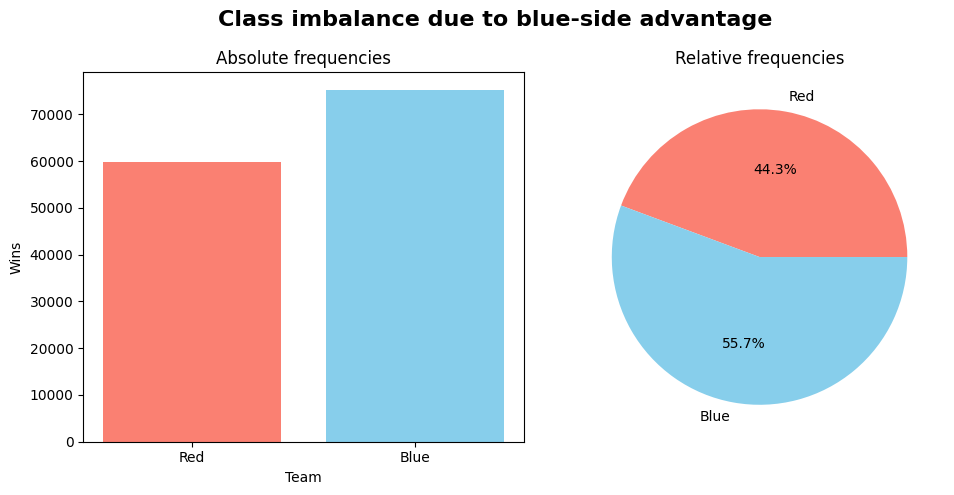

In [213]:

wins = matches[targets]
red_team_wins, blue_team_wins = get_win_counts(wins, targets)

print(f"Red Team Wins: {red_team_wins}")
print(f"Blue Team Wins: {blue_team_wins}")

colors = ['salmon', 'skyblue']
teams = ["Red", "Blue"]
team_wins = [red_team_wins, blue_team_wins]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle("Class imbalance due to blue-side advantage", fontsize=16, fontweight="bold")

ax[0].bar(teams, team_wins, color=colors)
ax[0].set_title("Absolute frequencies")
ax[0].set_xlabel("Team")
ax[0].set_ylabel("Wins")

ax[1].pie(team_wins, labels=teams, colors=colors, autopct='%1.1f%%')
ax[1].set_title("Relative frequencies")

plt.tight_layout()
plt.plot()

### Elo Distribution

Because the blue-side advantage is so strong, I'm curious what the elo distribution is in this dataset. I would expect the games to be more skewed towards high-elo, as high-elo players are more capable of making use of small advantages. Here are some observations:

- Iron, Bronze, Silver, and Gold matches make up less than 31% of all total games. 
- Challenger and Grandmaster matches make up less than 2% of all total games.
- The vast majority of matches are played in Gold, Platinum, Emerald, Diamond, and Master, with frequencies for the first 4 being roughly equal.
- There are a disproportionate amount of games played in Master elo.



In [224]:
match_metadata_df = pd.read_csv("../data/MatchTbl.csv")
ranks_df = pd.read_csv("../data/RankTbl.csv")

match_metadata_merged_df = pd.merge(
	match_metadata_df, 
	ranks_df, 
	left_on="RankFk", 
	right_on="RankId"
)

match_metadata_merged_df = match_metadata_merged_df.drop(columns=["RankFk"])
match_metadata_merged_df.head()

ranks = match_metadata_merged["RankName"].unique()
rank_counts_df = match_metadata_merged_df["RankName"].value_counts()

print(f"Ranks: {ranks}")
print(f"Unranked Frequency: {rank_counts["Unranked"]}")
print(f"Elo with most games: {rank_counts.idxmax()}")
print(f"Elo with fewest games: {rank_counts.idxmin()}")
print(f"Top 3 elos with most games: \n{rank_counts.nlargest(3)}")
print(f"Top 3 elos with fewest games: \n{rank_counts.nsmallest(3)}")

Ranks: ['Unranked' 'Emerald' 'Gold' 'Platinum' 'Bronze' 'Silver' 'Diamond'
 'Master' 'Iron' 'Challenger' 'Grandmaster']
Unranked Frequency: 17613
Elo with most games: Master
Elo with fewest games: Challenger
Top 3 elos with most games: 
RankName
Master      31308
Platinum    22384
Gold        20541
Name: count, dtype: int64
Top 3 elos with fewest games: 
RankName
Challenger      439
Iron           2226
Grandmaster    2358
Name: count, dtype: int64


In [ ]:
rank_counts_df = rank_counts_df.reindex(RANK_ORDER)

print("Rank Frequencies")
rank_counts_df

Rank Frequencies


RankName
Iron            2226
Bronze          4755
Silver         12295
Gold           20541
Platinum       22384
Emerald        18132
Diamond        17812
Master         31308
Grandmaster     2358
Challenger       439
Name: count, dtype: int64

[]

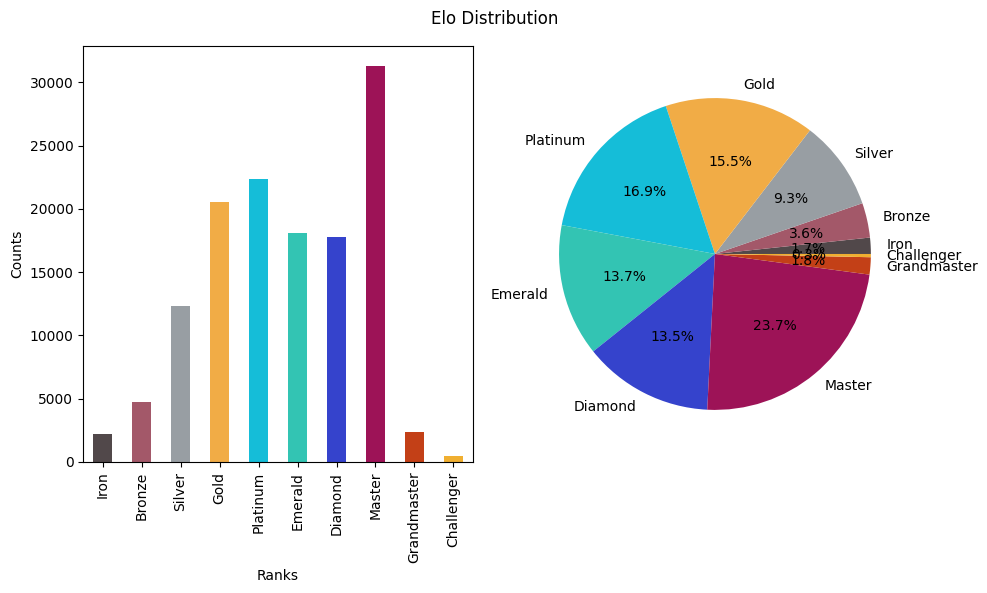

In [216]:
rank_colors = [RANK_COLORS[rank] for rank in RANK_ORDER]

fig, ax = plt.subplots(1, 2, figsize=(10, 6))

fig.suptitle("Elo Distribution")

rank_counts_df.plot(kind="bar", xlabel="Ranks", ylabel="Counts", ax=ax[0], color=rank_colors)
rank_counts_df.plot(kind='pie', ylabel="", ax=ax[1], colors=rank_colors, autopct="%1.1f%%")

plt.tight_layout()
plt.plot()